# Algoritmo rutas seguras contra el acoso a la mujer en Medellín

In [1]:
import pandas as pd
from queue import PriorityQueue
from collections import namedtuple, deque
from pprint import pprint as pp
import networkx as nx
from regex import P
import gmplot # libreria para graficar el mapa

#### La función *inicioProceso* se encarga de:
 - Lee y carga el csv
 - Convierte el csv en diferentes dataframes
 - Se genera el dataframe 3 el cual contiene los nodos unicos
 - Se genera el dataframe 4 el cual contiene los destinos de cada nodo origen con la distancia
 - Se genera el dataframeAcoso el cual contiene los destinos de cada nodo origen con el acoso
 - En el dataframe Acoso para la columna harassmentRisk si el valor es vacio se modifica por el promedio de los valores de la      columna
 - Se agrega una nueva columna(ponderado) al dataframe acoso donde se multiplica el acoso por la distancia

In [2]:
def inicioProceso():
    # Lectura del csv en dataframe

    df = pd.read_csv("calles_de_medellin_con_acoso.csv", sep=';')

    # Se crea un dataframe con 4 campos
    df1 = df[['origin', 'destination', 'length', 'harassmentRisk']]

    # Dataframe solo con campo origen para mas adelante utilizarlo como los nodos
    df3 = df[['origin']]

    # Cantidad de nodos
    nodos = df3.origin.unique()
    df3 = pd.DataFrame(nodos, columns=['origin'])
    df3.insert(0, 'id', df3.index)
    # print(df3.head())

    #  escribe los nodos en un txt
    with open("Nodos.txt", "w") as text_file:
        txt = str((df3.to_string()))
        text_file.write(txt + "\r\n")

    # Almacena en un dataframe nuevo los destinos de cada nodo origen
    df4 = (df1.loc[df1['origin'].isin(df3["origin"])])
    # print(df4)

    #  escribe los Destinos en un txt
    with open("Destinos.txt", "w") as text_file:
        txt = str((df4.to_string()))
        text_file.write(txt + "\r\n")

    # se convierte la columna distancia en float para el dijkstra
    df4['length'] = df4['length'].fillna(0).astype(float)

    # se crea nuevo datframe para el camino con el menor acoso
    dfAcoso = df4[['origin', 'destination', 'length', 'harassmentRisk']]

    # se llenan los vacios con el promedio
    dfAcoso['harassmentRisk'] = dfAcoso['harassmentRisk'].fillna(
        df["harassmentRisk"].mean())

    # se agrega una columna nueva donde se multiplica el acoso por la distancia
    dfAcoso['ponderado'] = dfAcoso['length'] * dfAcoso['harassmentRisk']

#     print(dfAcoso.head())

    # Se elimina la columna harassmentRisk ya que para el primer dijkstra solo se necesita la distancia
    df4.drop('harassmentRisk', inplace=True, axis=1)

    return df1, df3, df4, dfAcoso


#### La función *CalculoDistancia* se encarga de:
 - Se crea una nueva columna llamada test a la cual se combina la palabra "weight" junto con la distancia o acoso dependiendo del proceso
 -Se crea el grafo utilizando la libreria **networkx** y se llena con los nodos y las aristas, la documentación de la libreria se encuentra en https://networkx.guide/algorithms/shortest-path/dijkstra/ 
 

In [3]:
def CalculoDistancia(df, inicio, fin, nombre):
    # se agrega la columna test con la palabra weight para proximamente crear una columna nueva
    # la columna nueva se llamará merged con la siguiente estructura {'weight': 42.867}
    df.insert(loc=3,
              column='test',
              value='weight')
    
    # aca se genera la columna nueva merged dependiendo el proceso
    # si es con el ponderad (distancia*acoso) o con la distancia
    if nombre == 'Acoso':
        df['merged'] = df.apply(lambda row: {row['test']: row['ponderado']}, axis=1)
    else:
        df['merged'] = df.apply(lambda row: {row['test']: row['length']}, axis=1)

#     print(df.head())

    # el nuevo dataframe se convierte en una lista para crear el grafo con la libreria networkx
    df1 = df[['origin', 'destination', 'merged']]
    records = df1.to_records(index=False)
    edges = list(records)

    # se crea el objeto grafo
    G = nx.Graph()

    # agrego los nodos unicos del grafo
    for i in range(len(df)):
        G.add_node(df["origin"][i])

    # agrego los bordes/aristas del grafo
    G.add_edges_from(edges)

#     print(G)

    # Retorna el camino más corto en coordenadas, desde el inicio hasta el fin ingresado
    # Dependiendo si es solo la distancia o la distancia con menor acoso
    camino = nx.shortest_path(G, source=inicio, target=fin, weight='weight')

    # Retorna el valor de la distancia recorrida usando el camino mas corto
    # Dependiendo si es solo la distancia o la distancia con menor acoso
    length = nx.shortest_path_length(
        G, source=inicio, target=fin, weight='weight')

    texto = ''
    if nombre == 'Acoso':
        texto = 'Distancia recorrida con menor riesgo de acoso: ' + str(length)
    else:
        texto = 'Distancia recorrida: ' + str(length)

    print('El camino más corto desde el nodo ' + str(inicio) +
          ' hasta el nodo ' + str(fin) + ' es: ' + str(camino))
    print(texto)

    return camino


#### Clase*Graph* se encarga de:
 - Se crea el grafo y tambien implementa el algoritmo de Dijkstra
 - Esta implementación fue tomada de http://www.rosettacode.org/wiki/Dijkstra%27s_algorithm#Python

In [4]:
class Graph:
    def __init__(self, edges):
        self.edges = [Edge(*edge) for edge in edges]
        self.vertices = {e.start for e in self.edges} | {
            e.end for e in self.edges}

    # algoritmo de dijkstra
    def dijkstra(self, source, dest):
        assert source in self.vertices
        dist = {vertex: inf for vertex in self.vertices}
        previous = {vertex: None for vertex in self.vertices}
        dist[source] = 0
        q = self.vertices.copy()
        neighbours = {vertex: set() for vertex in self.vertices}
        for start, end, cost in self.edges:
            neighbours[start].add((end, cost))
            neighbours[end].add((start, cost))

        while q:
            u = min(q, key=lambda vertex: dist[vertex])
            q.remove(u)
            if dist[u] == inf or u == dest:
                break
            for v, cost in neighbours[u]:
                alt = dist[u] + cost
                if alt < dist[v]:
                    dist[v] = alt
                    previous[v] = u
        s, u = deque(), dest
        while previous[u]:
            s.appendleft(u)
            u = previous[u]
        s.appendleft(u)
        return s


#### La función *dibujarMapa* se encarga de:
 - Se utiliza google maps para graficar los dos grafos arrojados por el algoritmo de dijkstra
 - Se generan dos archivos HTML con los mapas (Acoso, distancia)
 - Información consultada en https://github.com/gmplot/gmplot

In [5]:
def dibujarMapa(origen_lat,origen_long,destino_lat,destino_long,camino,proceso):
    # Crea el plotter para mapa
    gmap = gmplot.GoogleMapPlotter(origen_lat,origen_long, 14)

    # Marca el punto de origen en el mapa
    gmap.marker(origen_lat,origen_long, color='red')

    # Resalta en el mapa los nodos por los que va el camino mas corto
    nodos_latitud, nodos_longitud = zip(*camino)
    gmap.scatter(nodos_latitud, nodos_longitud, color='yellow', size=5, marker=False)

    # grafica el poligono y la ruta mas corta en el mapa
    poligono = zip(*camino)
    gmap.polygon(*poligono, color='cornflowerblue', edge_width=10)

    # Marca el punto destino en el mapa
    gmap.marker(destino_lat,destino_long, color='green')

    # Genera un html con el mapa
    if proceso == 'Acoso':
        gmap.draw('mapAcoso.html')
    else:
        gmap.draw('mapDistancia.html')


#### La función *transfCamino* se encarga de:
 - Para graficar el mapa en google maps las coordenadas deben de empezar por la latitud, longitud (6.2115169,-75.5728593), pero en el CSV las coordenadas estaban invertidas(-75.5728593,6.2115169)
 - El objetivo de la función es invertir las coordenadas del camino más corto obtenidos por el dijkstra

In [6]:
def transfCamino(camino):
    # se invirten las coordenadas para poder graficarlas usando maps de google
    # en maps primero se usa la latitud (6.200) y despues la longitud -75.5700
    dfRuta = pd.DataFrame (camino, columns = ['ruta'])
    dfRuta['ruta']=( dfRuta.ruta.str.split()
              .apply(lambda x: ', '.join(x[::-1]).rstrip(','))
              .where(dfRuta['ruta'].str.contains(','),dfRuta['ruta']) )

    dfRuta['ruta'] = dfRuta['ruta'].str.replace(')','')
    dfRuta['ruta'] = dfRuta['ruta'].str.replace('(','')
    dfRuta['ruta'] = dfRuta['ruta'].str.replace(' ','')

#     print(dfRuta.head())

    # se genera la lista con los valores para graficar el mapa
    foo = lambda x: pd.Series([i for i in reversed(x.split(','))])
    rev = dfRuta['ruta'].apply(foo)
    rev = rev.astype(float)
    rev2 = rev[[1,0]]

    # se convierte en una lista de tuplas para poder ser leido por la funcion y graficarlo
    # ejemplo (6.338773,-75.6909483),(6.338773,-75.6909483),(6.338773,-75.6909483)
    records = rev2.to_records(index=False)
    result_camino = list(records)

    return result_camino


### Main

- Se define el paso a paso de la ejecución del código
- En el main se ingresan las coordenadas de origen y destino para el cual se desea generar el mapa

In [7]:
if __name__ == "__main__":
    inf = float('inf')

    # df1 dataframe con 4 campos origin,destination,length,harassmentRisk
    # df3 Dataframe solo con campo origen para mas adelante utilizarlo como los nodos
    # df4 Almacena en un dataframe nuevo los destinos de cada nodo origen
    # dfAcoso se crea nuevo datframe para el camino con el menor acoso

    adj_list = {}
    mylist = []
    df1, df3, df4, dfAcoso = inicioProceso()

    origen_x,origen_y = input("Ingrese las coordenadas de origen: ").split(',')
    destino_x,destino_y = input("Ingrese las coordenadas destino: ").split(',')

    origen= ("(" + str(origen_x) + ', ' + str(origen_y) + ")")
    destino= ("(" + str(destino_x) +', ' + str(destino_y) + ")")

    # Este es para calcular solo el de menor distancia
    camino = CalculoDistancia(df4, origen, destino, 'Distancia')
   
    # funcion para invertir las coordenadas y convertirlas en una lista de tuplas
    result_camino = transfCamino(camino)

    # se envian las cordenadas del origen, del destino y el camino arrojado por el dijkstra
    dibujarMapa(float(origen_y),float(origen_x),float(destino_y),float(destino_x),result_camino,'Distancia')

    # Este es para calcular el de menor distancia y con menos riesgo
    caminoAcoso = CalculoDistancia(dfAcoso, origen, destino, 'Acoso')

     # funcion para invertir las coordenadas y convertirlas en una lista de tuplas
    result_camino = transfCamino(caminoAcoso)

    # se envian las cordenadas del origen, del destino y el camino arrojado por el dijkstra
    dibujarMapa(float(origen_y),float(origen_x),float(destino_y),float(destino_x),result_camino,'Acoso')


Ingrese las coordenadas de origen: -75.5728593,6.2115169
Ingrese las coordenadas destino: -75.5963031,6.2329049
El camino más corto desde el nodo (-75.5728593, 6.2115169) hasta el nodo (-75.5963031, 6.2329049) es: ['(-75.5728593, 6.2115169)', '(-75.5732903, 6.2116756)', '(-75.5733588, 6.211705)', '(-75.5743239, 6.2122137)', '(-75.5746022, 6.2124115)', '(-75.5746775, 6.212465)', '(-75.5747545, 6.2125782)', '(-75.5762218, 6.213246)', '(-75.5775144, 6.2135088)', '(-75.5787992, 6.2137472)', '(-75.5800313, 6.2141121)', '(-75.5801248, 6.2141477)', '(-75.5800954, 6.2142447)', '(-75.5810773, 6.2145997)', '(-75.5814246, 6.2148345)', '(-75.5814316, 6.2149115)', '(-75.5817852, 6.2151735)', '(-75.5818797, 6.2151517)', '(-75.582413, 6.2152981)', '(-75.5846939, 6.2164844)', '(-75.5856797, 6.2169999)', '(-75.5857858, 6.2172052)', '(-75.5854762, 6.2184218)', '(-75.5858815, 6.2185282)', '(-75.5859223, 6.2186135)', '(-75.5862374, 6.2188681)', '(-75.5862122, 6.2189291)', '(-75.5862768, 6.2189868)', '(-75

C:\Users\Carlos\AppData\Local\Temp/ipykernel_1648/3959023813.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dfRuta['ruta'] = dfRuta['ruta'].str.replace(')','')
C:\Users\Carlos\AppData\Local\Temp/ipykernel_1648/3959023813.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dfRuta['ruta'] = dfRuta['ruta'].str.replace('(','')


El camino más corto desde el nodo (-75.5728593, 6.2115169) hasta el nodo (-75.5963031, 6.2329049) es: ['(-75.5728593, 6.2115169)', '(-75.5724985, 6.2113756)', '(-75.5719919, 6.2111787)', '(-75.57125, 6.2108943)', '(-75.5711466, 6.2108547)', '(-75.5706449, 6.2106721)', '(-75.5705202, 6.2106275)', '(-75.570427, 6.2105879)', '(-75.5704051, 6.2106446)', '(-75.5701763, 6.2112341)', '(-75.5701282, 6.211394)', '(-75.5700441, 6.2116409)', '(-75.5699843, 6.2119378)', '(-75.5699401, 6.2127887)', '(-75.5699408, 6.2128236)', '(-75.5699235, 6.2130518)', '(-75.5699145, 6.2146317)', '(-75.5699082, 6.2147567)', '(-75.5698764, 6.2166636)', '(-75.5698362, 6.2178228)', '(-75.5696068, 6.2190788)', '(-75.5694036, 6.2199946)', '(-75.569261, 6.2222417)', '(-75.5692068, 6.2226773)', '(-75.5691617, 6.2233874)', '(-75.5691674, 6.2235985)', '(-75.5691554, 6.2247955)', '(-75.5691542, 6.2251362)', '(-75.5691396, 6.2259464)', '(-75.569098, 6.2264984)', '(-75.5688346, 6.2274493)', '(-75.5698076, 6.2277458)', '(-75.5

### Mapa con el menor riesgo de acoso

 - El indicador rojo corresponde a la coordenada ingresada como origen
 - El indicador verde corresponde a la coordenada ingresada como destino

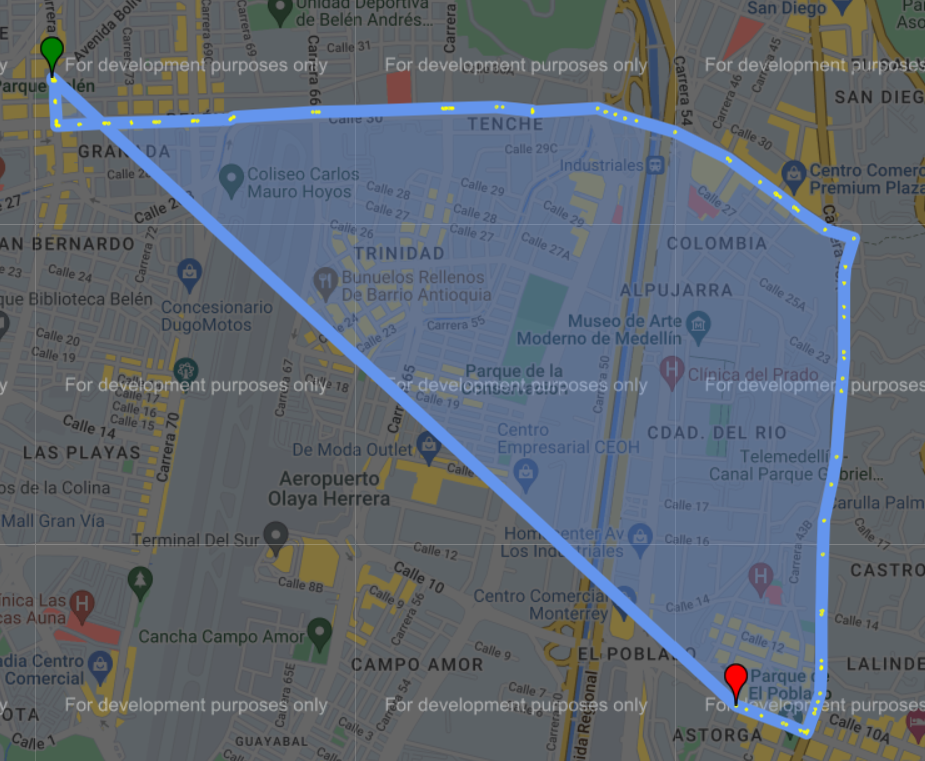

### Mapa menor distancia

 - El indicador rojo corresponde a la coordenada ingresada como origen
 - El indicador verde corresponde a la coordenada ingresada como destino

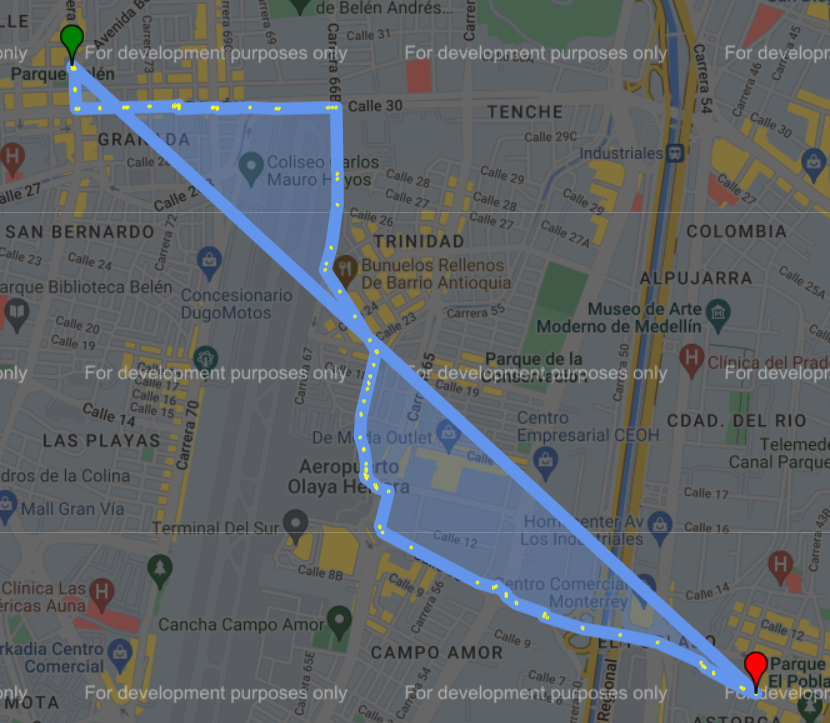

# Dataframes 

### Dataframe para calcular la ruta con menor acoso

In [8]:
print(dfAcoso.head())

                     origin               destination  length    test  \
0  (-75.5728593, 6.2115169)  (-75.5724985, 6.2113756)  42.867  weight   
1  (-75.5705202, 6.2106275)   (-75.570427, 6.2105879)  11.204  weight   
2  (-75.5705202, 6.2106275)  (-75.5705604, 6.2105262)  12.109  weight   
3  (-75.5687719, 6.2099661)  (-75.5688022, 6.2098867)   9.443  weight   
4  (-75.5687719, 6.2099661)   (-75.568715, 6.2099443)   6.741  weight   

   harassmentRisk  ponderado                          merged  
0        0.526539  22.571161  {'weight': 22.571160716060685}  
1        0.414356   4.642447   {'weight': 4.642446677901566}  
2        0.526539   6.375865   {'weight': 6.375864537074646}  
3        0.302173   2.853420  {'weight': 2.8534201486483926}  
4        0.302173   2.036949   {'weight': 2.036948556818682}  


### Dataframe para calcular la menor distancia

In [12]:
print(df4.head())

                     origin               destination  length    test  \
0  (-75.5728593, 6.2115169)  (-75.5724985, 6.2113756)  42.867  weight   
1  (-75.5705202, 6.2106275)   (-75.570427, 6.2105879)  11.204  weight   
2  (-75.5705202, 6.2106275)  (-75.5705604, 6.2105262)  12.109  weight   
3  (-75.5687719, 6.2099661)  (-75.5688022, 6.2098867)   9.443  weight   
4  (-75.5687719, 6.2099661)   (-75.568715, 6.2099443)   6.741  weight   

               merged  
0  {'weight': 42.867}  
1  {'weight': 11.204}  
2  {'weight': 12.109}  
3   {'weight': 9.443}  
4   {'weight': 6.741}  
